In [29]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt
import os
import pandas as pd

In [30]:
#variáveis auxiliares

pasta_resultados = "../results/"

In [31]:
#inicialização das variáveis

pontos_cubo = [(2, 2, 2),
              (-2, 2, 2),
              (-2, 2, -2),     
              (2, 2, -2),
              (2, -2, 2),
              (-2, -2, 2),
              (-2, -2, -2),
              (2, -2, -2)]

pontos_camera = [(422, 323),
                (178, 323),
                (118, 483),
                (482, 483),
                (438, 73),
                (162, 73),
                (78, 117),
                (522, 117)]

#pontos_cubo = np.array(pontos_cubo)
#pontos_camera = np.array(pontos_camera)

In [32]:
def plot_3d_data(points_3d):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for p in points_3d:
        ax.scatter(p[0], p[1], p[2], marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
    
def plot_2d_data(points_2d):
    fig = plt.figure()
    ax = fig.add_subplot()

    for p in points_2d:
        ax.scatter(p[0], p[1], marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    plt.show()

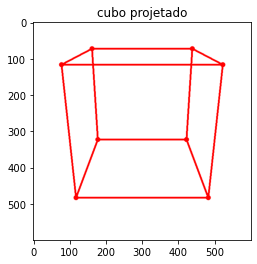

In [33]:
# exercicio 1
#Gere a imagem das arestas do cubo conforme projetado no plano da câmera.

#cria uma imagem branca
height = 600
width = 600

blank_image = np.zeros((height,width,3), np.uint8)
blank_image[:,:] = (255, 255, 255)

#marca pontos na imagem
for point in pontos_camera:
    cv2.circle(blank_image, (point[0], point[1]), 7, (255, 0, 0), -1)

    
#traça linhas conectando os pontos
cv2.line(blank_image, pontos_camera[6], pontos_camera[5], (255, 0, 0), 3)
cv2.line(blank_image, pontos_camera[5], pontos_camera[4], (255, 0, 0), 3)
cv2.line(blank_image, pontos_camera[4], pontos_camera[7], (255, 0, 0), 3)
cv2.line(blank_image, pontos_camera[6], pontos_camera[7], (255, 0, 0), 3)

cv2.line(blank_image, pontos_camera[6], pontos_camera[2], (255, 0, 0), 3)
cv2.line(blank_image, pontos_camera[5], pontos_camera[1], (255, 0, 0), 3)
cv2.line(blank_image, pontos_camera[4], pontos_camera[0], (255, 0, 0), 3)
cv2.line(blank_image, pontos_camera[7], pontos_camera[3], (255, 0, 0), 3)

cv2.line(blank_image, pontos_camera[2], pontos_camera[1], (255, 0, 0), 3)
cv2.line(blank_image, pontos_camera[1], pontos_camera[0], (255, 0, 0), 3)
cv2.line(blank_image, pontos_camera[0], pontos_camera[3], (255, 0, 0), 3)
cv2.line(blank_image, pontos_camera[3], pontos_camera[2], (255, 0, 0), 3)

#renomeia a variável para n ter confusao
imagem_cubo = blank_image.copy()


# cv2.imshow('imagem branca', blank_image)
plt.imshow(imagem_cubo)
plt.title('cubo projetado')
plt.show()

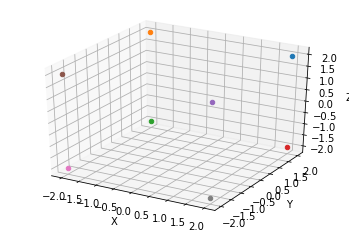

In [34]:
plot_3d_data(pontos_cubo)

In [35]:
#exercício 2
#Utilizando as correspondências dadas, encontre a matriz de projeção P da câmera

#adiciona o valor 1 à terceira coordenada do ponto

for i in range(len(pontos_camera)):
    pontos_camera[i] = (pontos_camera[i][0], pontos_camera[i][1], 1)
    pontos_cubo[i] = (pontos_cubo[i][0], pontos_cubo[i][1], pontos_cubo[i][2], 1)
    
pontos_cubo = np.array(pontos_cubo)
pontos_camera = np.array(pontos_camera)


In [36]:
#funções do metodo dlt para encontrar projeções

def normalization_2d(points):

    points = np.asarray(points)

    m = np.mean(points, 0)
    s = np.std(points)

    T = np.array([[s, 0, m[0]], [0, s, m[1]], [0, 0, 1]])
    T = np.linalg.inv(T)
    normalized_points = np.dot( T, points.T )
    normalized_points = normalized_points[0:2,:].T

    return T, normalized_points


def normalization_3d(points):

    points = np.asarray(points)

    m = np.mean(points, 0)
    s = np.std(points)

    T = np.array([[s, 0, 0, m[0]], [0, s, 0, m[1]], [0, 0, s, m[2]], [0, 0, 0, 1]])

    T = np.linalg.inv(T)
    normalized_points = np.dot( T, points.T )
    normalized_points = normalized_points[0:3,:].T

    return T, normalized_points

def create_projection_dlt(points_2d, points_3d):

    #aplica normalizacao dos dados para se obter melhores resultados
    T1, points_2d_norm = normalization_2d(points_2d)
    T2, points_3d_norm = normalization_3d(points_3d)

    A = []

    for i in range(len(points_2d_norm)):
        x,y,z = points_3d_norm[i,0], points_3d_norm[i,1], points_3d_norm[i,2]
        u,v = points_2d_norm[i,0], points_2d_norm[i,1]
        A.append( [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u] )
        A.append( [0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v] )

    #aplica svd para encontrar os 11 parametros
    U, S, Vh = np.linalg.svd(A)

    #recupera parametros do svd
    L = Vh[-1,:] / Vh[-1,-1]

    #matriz de projecao
    H = L.reshape(3,4)


    #denormalizacao
    H = np.dot( np.dot( np.linalg.pinv(T1), H ), T2 );
    H = H / H[-1,-1]

    #Erro medio da DLT
    new_points_2d = np.dot( H, points_3d.T )
    new_points_2d = new_points_2d/new_points_2d[2,:]

    #distancia media
    error = np.sqrt( np.mean(np.sum( (new_points_2d.T - points_2d)**2,1 )) )

    return H, error

In [37]:
#calcula matriz de projeção e erro com base nos pontos da camera e do cubo

projection_matrix, projectionError = create_projection_dlt(pontos_camera, pontos_cubo)

print("Matriz de projecao para os pontos de 3d para 2d")

print(projection_matrix)

Matriz de projecao para os pontos de 3d para 2d
[[ 7.86090778e+01  1.15453160e+01  3.21015763e+01  3.00000000e+02]
 [ 8.22602305e-15  8.34795054e+01  2.82447560e-02  2.49938656e+02]
 [-2.62219619e-15  3.84843868e-02  1.07005254e-01  1.00000000e+00]]


In [42]:
P_arredondado = []
for line in projection_matrix:
    linha = []
    for value in line:
        linha.append(np.round(value, 2))
    P_arredondado.append(linha)
        
pd.DataFrame( P_arredondado )

,0,1,2,3
0,78.61,11.55,32.10,300.00
1,0.00,83.48,0.03,249.94
2,-0.00,0.04,0.11,1.00


In [38]:
#Validação da matrix de projeção
#Os pontos projetados devem ser similares aos pontos da camera se tudo estiver certo.

pontos_projetados = np.dot(projection_matrix, pontos_cubo.T).T

for p in pontos_projetados:
    p=p/p[2]
    print(p)

[421.78209034 322.97509487   1.        ]
[178.21790966 322.97509487   1.        ]
[117.81487933 483.03747032   1.        ]
[482.18512067 483.03747032   1.        ]
[438.26946778  73.02822055   1.        ]
[161.73053222  73.02822055   1.        ]
[ 78.26013871 116.95448882   1.        ]
[521.73986129 116.95448882   1.        ]


In [39]:
#exercício 3

'''
Fatorize a matriz P para encontrar os parâmetros intrínsecos (K) e extrínsecos (R, t) da
câmera. Qual a posição do centro ótico da câmera do robô em relação ao centro do cubo?
Qual a distância focal da câmera?
'''
from scipy import linalg

k, rt = linalg.rq(projection_matrix, mode='full')

print(k)
print("\n\n")
print(rt)

[[ 0.00000000e+00  7.86090778e+01 -4.02786476e-12 -3.01933446e+02]
 [ 0.00000000e+00  0.00000000e+00  7.85441572e+01 -2.51533250e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00644482e+00]]



[[-5.62739183e-16  3.37968160e-01  9.34350830e-01 -1.12986946e-01]
 [ 1.00000000e+00 -7.69241301e-15  3.57257325e-15  2.53594988e-15]
 [ 8.44839374e-15  9.40380445e-01 -3.40124353e-01  2.05128201e-04]
 [ 2.60540483e-15 -3.82379501e-02 -1.06320041e-01 -9.93596451e-01]]


In [40]:
k_arredondado = []
for line in k:
    linha = []
    for value in line:
        linha.append(np.round(value, 2))
    k_arredondado.append(linha)
        
pd.DataFrame( k_arredondado )


,0,1,2,3
0,0.0,78.61,-0.00,-301.93
1,0.0,0.00,78.54,-251.53
2,0.0,0.00,0.00,-1.01


In [43]:
k_teorico = [["fmx", "s", "px"], ["0", "fmy", "py"], ["0", "0", "1"]]
pd.DataFrame( k_teorico )

,0,1,2
0,fmx,s,px
1,0,fmy,py
2,0,0,1


In [41]:
rt_arredondado = []
for line in rt:
    linha = []
    for value in line:
        linha.append(np.round(value, 2))
    rt_arredondado.append(linha)
        
pd.DataFrame( rt_arredondado )

,0,1,2,3
0,-0.0,0.34,0.93,-0.11
1,1.0,-0.00,0.00,0.00
2,0.0,0.94,-0.34,0.00
3,0.0,-0.04,-0.11,-0.99
